<a href="https://colab.research.google.com/github/mahera02/machine_learning/blob/master/HW3/HW3_pretrained_convnet_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1 - Using VGG19 for fast feature extraction using data augmentation

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG19 model to extract the features. We will feed these features to a densely connected classifier. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-18 01:22:59--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 2a00:1450:4013:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  49.1MB/s    in 1.3s    

2019-04-18 01:23:05 (49.1 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


## Build network with VGG19 convolution base and custom densely connected layers

### Load the convolutional base using VGG19

In [0]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3))

conv_base.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 3s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____

**Freeze the convolutional base**

In [0]:
conv_base.trainable = False
for layer in conv_base.layers:
  layer.trainable = False

**Concatenate the convolutional base and densely connected layers**

In [0]:
from keras import layers
from keras import models
from keras import optimizers

last_layer = conv_base.get_layer('block5_pool').output

network = layers.Flatten()(last_layer)
network = layers.Dense(256, activation='relu')(network)
network = layers.Dense(1, activation='sigmoid')(network)

# Configure and compile the model
model = models.Model(conv_base.input, network)


#model.add(conv_base)
#model.add(layers.Flatten())
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
#model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

**Fast feature extraction with data augmentation**
The final feature map in block5_pool has shape (7, 7, 512). That's the feature on top of which we'll stick a densely connected classifier

**Train the model end to end with frozen convolutional base**

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 38s 383ms/step - loss: 0.5912 - acc: 0.6790 - val_loss: 0.4266 - val_acc: 0.8170
Epoch 2/100
100/100 [==============================] - 31s 310ms/step - loss: 0.4810 - acc: 0.7650 - val_loss: 0.3505 - val_acc: 0.8480
Epoch 3/100
100/100 [==============================] - 31s 313ms/step - loss: 0.4205 - acc: 0.8125 - val_loss: 0.3017 - val_acc: 0.8670
Epoch 4/100
100/100 [==============================] - 32s 317ms/step - loss: 0.3934 - acc: 0.8225 - val_loss: 0.2832 - val_acc: 0.8770
Epoch 5/100
100/100 [==============================] - 31s 313ms/step - loss: 0.3735 - acc: 0.8290 - val_loss: 0.2727 - val_acc: 0.8790
Epoch 6/100
100/100 [==============================] - 33s 334ms/step - loss: 0.3566 - acc: 0.8425 - val_loss: 0.2831 - val_acc: 0.8770
Epoch 7/100
100/100 [==============================]

In [0]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Display curves of loss and accuracy during training

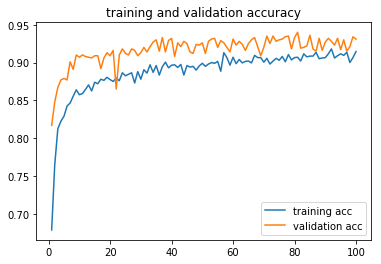

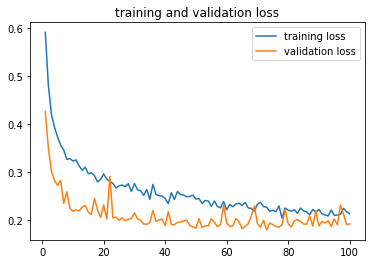

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc,label='training acc')
plt.plot(epochs, val_acc,label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss,label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

# Problem 2 - Fine Tuning with data augmentation

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 36s 363ms/step - loss: 0.2480 - acc: 0.8995 - val_loss: 0.2074 - val_acc: 0.9220
Epoch 2/100
100/100 [==============================] - 34s 335ms/step - loss: 0.1956 - acc: 0.9150 - val_loss: 0.1853 - val_acc: 0.9400
Epoch 3/100
100/100 [==============================] - 33s 334ms/step - loss: 0.1678 - acc: 0.9330 - val_loss: 0.1402 - val_acc: 0.9490
Epoch 4/100
100/100 [==============================] - 32s 322ms/step - loss: 0.1563 - acc: 0.9400 - val_loss: 0.1702 - val_acc: 0.9470
Epoch 5/100
100/100 [==============================] - 32s 320ms/step - loss: 0.1472 - acc: 0.9425 - val_loss: 0.1536 - val_acc: 0.9430
Epoch 6/100
100/100 [==============================] - 33s 326ms/step - loss: 0.1332 - acc: 0.9440 - val_loss: 0.1274 - val_acc: 0.9610
Epoch 7/100
100/100 [==============================] - 32s 320ms/step - loss: 0.1306 - acc: 0.9475 - val_loss: 0.1261 - val_acc: 0.9540
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

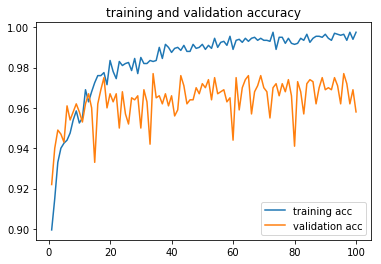

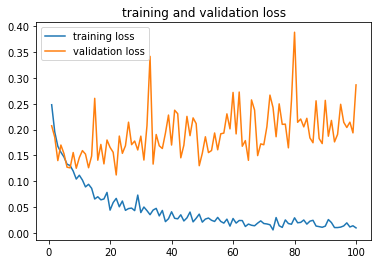

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss,  label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.1453525159576604
Validation accuracy: 0.9719999945163726


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)

# Problem 3 -  Visualize heatmaps of class activation for the the model obtained in Problem 2

In [1]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras import backend as K
from keras.applications import VGG19

Using TensorFlow backend.


list top three images of cats and dogs from the validation set

In [2]:
!ls /tmp/cats_and_dogs_filtered/validation/cats | head -3
!ls /tmp/cats_and_dogs_filtered/validation/dogs | head -3

cat.2000.jpg
cat.2001.jpg
cat.2002.jpg
dog.2000.jpg
dog.2001.jpg
dog.2002.jpg


In [3]:
vgg19_model = VGG19(weights='imagenet') 
last_conv_layer = vgg19_model.get_layer("block5_conv4")

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def show_superimposed_image(img_path, heatmap):

  img = cv2.imread(img_path)
  # resize the heatmap to be the same size as the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * 0.4 + img

  cv2_imshow(superimposed_img)

In [0]:
def process_image(img_path, idx=0):
  img = image.load_img(img_path, target_size=(224, 224))
  #
  plt.imshow(img)
  plt.grid(None)
  plt.show()
  #
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  #
  preds = vgg19_model.predict(x)
  print('Predicted:', decode_predictions(preds, top=3)[0])
  #
  #class_index = np.argmax(preds[0])
  
  class_index = np.argsort(preds[0])[-(1+idx)]
  
  class_output = vgg19_model.output[:, class_index]
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]

  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  iterate = K.function([vgg19_model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  #
  show_superimposed_image(img_path, heatmap)

call the function process_image which takes the image as input and shows its heatmap

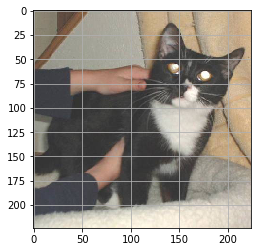

Predicted: [('n02124075', 'Egyptian_cat', 0.32163024), ('n03887697', 'paper_towel', 0.09209272), ('n02123045', 'tabby', 0.056254257)]


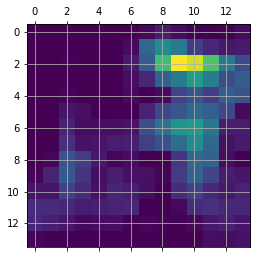

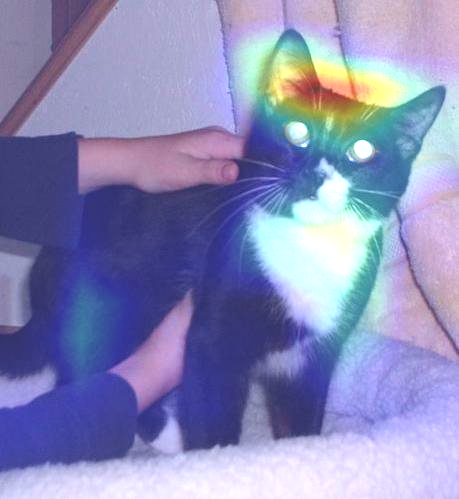

In [6]:
process_image('/tmp/cats_and_dogs_filtered/validation/cats/cat.2000.jpg')

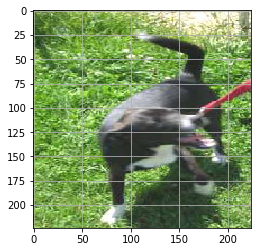

Predicted: [('n02093256', 'Staffordshire_bullterrier', 0.14730418), ('n02102040', 'English_springer', 0.13474815), ('n02093428', 'American_Staffordshire_terrier', 0.12617344)]


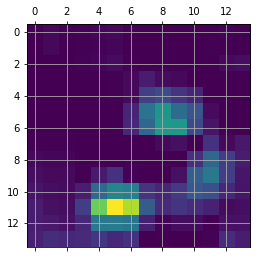

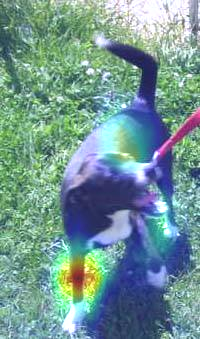

In [7]:
process_image('/tmp/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg')

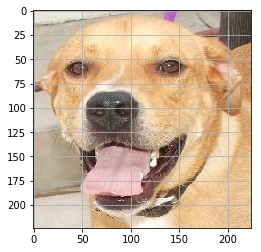

Predicted: [('n02099712', 'Labrador_retriever', 0.78212374), ('n02093256', 'Staffordshire_bullterrier', 0.031682175), ('n02093428', 'American_Staffordshire_terrier', 0.027616164)]


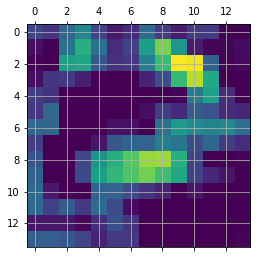

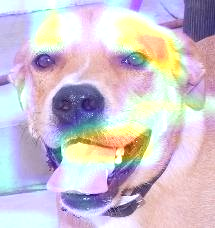

In [8]:
process_image('/tmp/cats_and_dogs_filtered/validation/dogs/dog.2001.jpg')

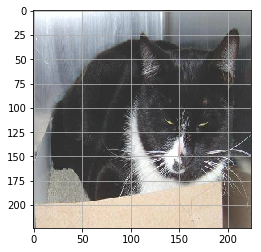

Predicted: [('n02124075', 'Egyptian_cat', 0.17199294), ('n02971356', 'carton', 0.12826574), ('n03207941', 'dishwasher', 0.06350011)]


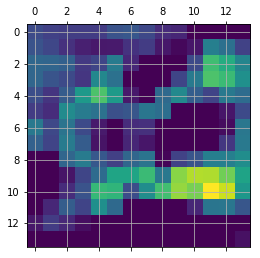

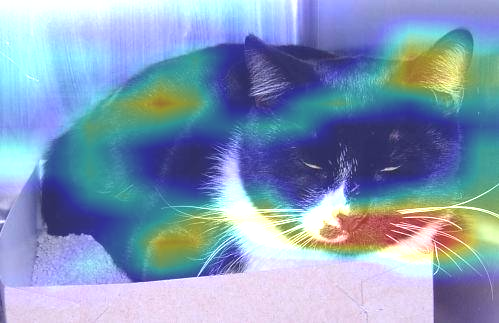

In [9]:
process_image('/tmp/cats_and_dogs_filtered/validation/cats/cat.2001.jpg')

# Problem 4 - Activation model and  t-SNE visualization 

In [0]:
img_path = '/tmp/cats_and_dogs_filtered/validation/dogs/dog.2001.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

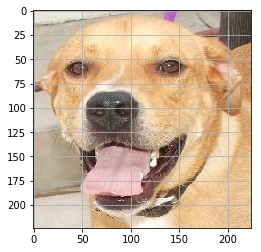

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.grid(None)
plt.show()

In [0]:
model.predict(img_tensor)

array([[1.]], dtype=float32)

**Instantiate a model from an input tensor and a list of output tensors**

In [0]:
#from keras import models

layer_outputs = [layer.output for layer in model.layers[1:25]]

activation_model = models.Model(input=model.input, outputs=layer_outputs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  after removing the cwd from sys.path.


In [0]:
activations = activation_model.predict(img_tensor)
len(activations)

24

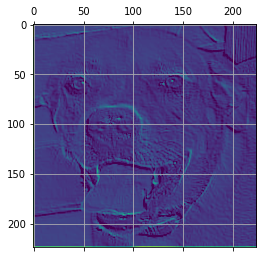

In [0]:
first_layer_activation = activations[0]

plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.grid(None)
plt.show()

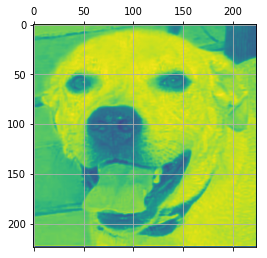

In [0]:
second_layer_activation = activations[1]

plt.matshow(second_layer_activation[0, :, :, 4], cmap='viridis')
plt.grid(None)
plt.show()

In [0]:
def visualize_activations(layerIndex):
  
  layer_name = model.layers[layerIndex].name
  
  images_per_row = 16

  layer_activation = activations[layerIndex-1]
  # the feature map has shape (1, size, size, n_features)
  n_features = activations[layerIndex-1].shape[-1] 
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]

      channel_image -= channel_image.mean()
      if(channel_image.std() != 0):
        channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[
          col * size : (col + 1) * size,
          row * size : (row + 1) * size] = channel_image


  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

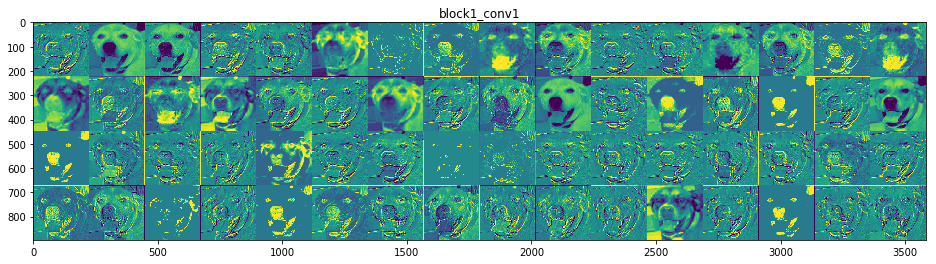

In [0]:
visualize_activations(1)

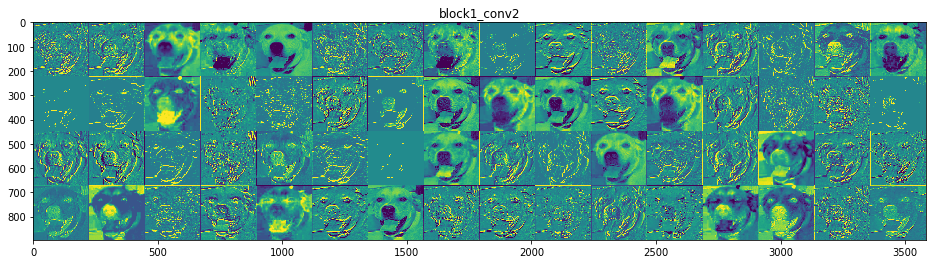

In [0]:
visualize_activations(2)

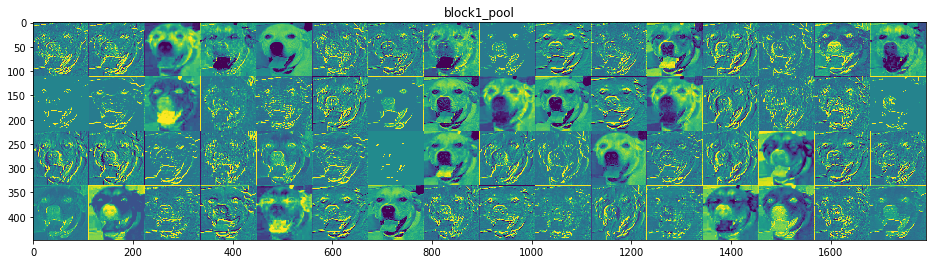

In [0]:
visualize_activations(3)

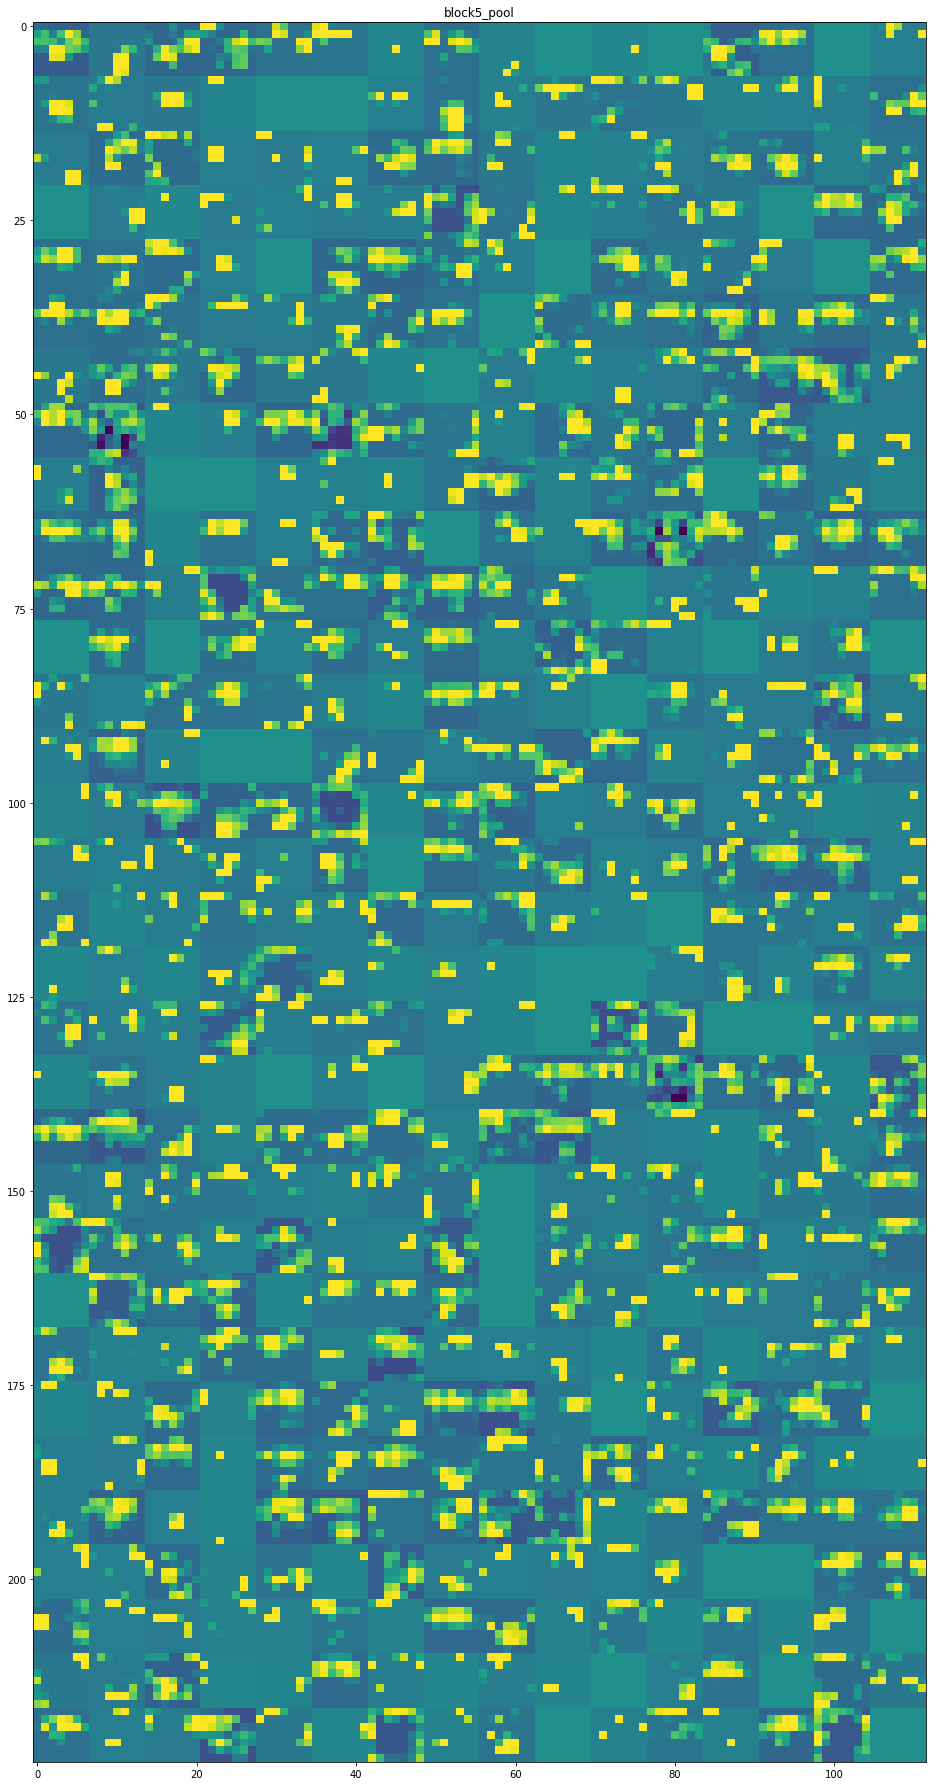

In [0]:
visualize_activations(21)

# t-SNE visualization for last conv layer (dense_1)

In [0]:
val_cat_fnames = os.listdir(validation_cats_dir)
val_dog_fnames = os.listdir(validation_dogs_dir)


In [0]:
layer = model.get_layer('dense_1')
layer_output = layer.output

In [0]:
from keras.preprocessing import image
import numpy as np

img_tensors = []
true_labels = []

#loading validation images (500 cats, 500 dogs)
val_cat = [os.path.join(validation_cats_dir, fname) 
                for fname in val_cat_fnames[0:]]
val_dog = [os.path.join(validation_dogs_dir, fname) 
                for fname in val_dog_fnames[0:]]

for i, img_path in enumerate(val_cat+val_dog):
  # Set up subplot; subplot indices start at 1
      
  true_label = (img_path)[39:42]
  true_labels.append(true_label)
  
  pred_img = image.load_img(img_path, target_size=(224,224))
  img_tensor = image.img_to_array(pred_img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  img_tensors.append(img_tensor)
  
print("length of img_tensors ", len(img_tensors)) 
print("length of true_labels ", len(true_labels))

In [0]:
activation_model = models.Model(input=model.input, outputs=[layer_output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [0]:
img_tensors = np.asarray(img_tensors)
img_tensors_array = np.concatenate((img_tensors))
print ("img_tensors_array ",img_tensors_array.shape)

activations = activation_model.predict(img_tensors_array)

img_tensors_array  (1000, 224, 224, 3)


In [0]:
activations.shape

(1000, 256)

**Load Packages**

In [0]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

In [0]:
class_names = ['cats', 'dogs']

**Visualization of the feature vectors produce by the convnet**

In [0]:
def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

**t-SNE**

In [0]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

cat_dog_tsne = TSNE(random_state=42).fit_transform(activations)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

t-SNE done! Time elapsed: 5.525797128677368 seconds


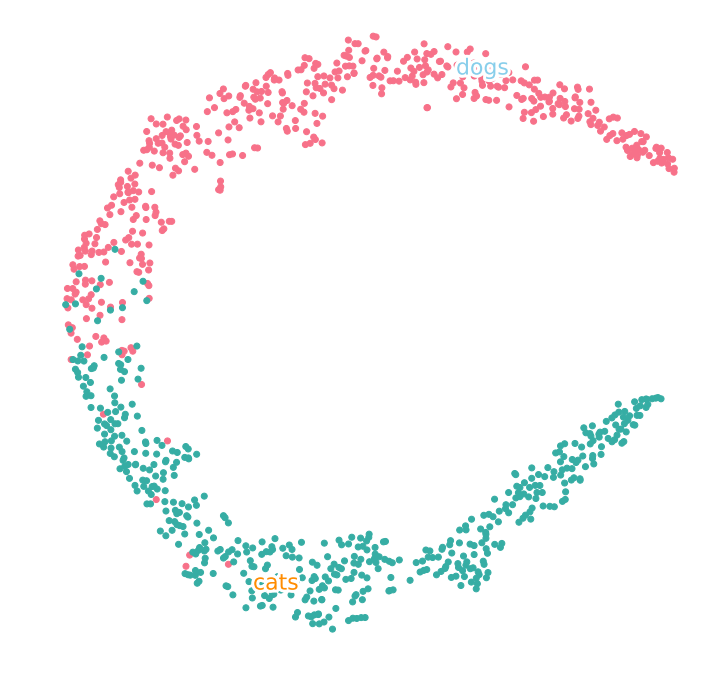

In [0]:
# visualize t-SNE output
data_scatter(cat_dog_tsne, validation_generator.classes)